### Aerodynamics sizing process

- Horizontal and vertical tailplane sizing
- Flaps sizing
- Ailerons sizing
- Neutral point location
- Parasitic drag coefficient $C_{D0}$
- Landing gear geometry analysis

In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
from sizing_functions import *

- INPUT DATA FOR SIZING AND ANALYSIS

In [39]:
#---- INPUTS FOR TAILPLANE SIZING ----
ht_V = 0.6
ht_arm = 1.0
ht_AR = 5.8
ht_taper = 1

vt_V = 0.05
vt_arm = 1.0
vt_AR = 2
vt_taper = 1

#---- INPUTS FOR PARASITIC DRAG ESTIMATION ----
# airspeed at which CD0 is estimated
V_drag = 15.0
# laminar/turbulent surface ratio
w_x_tr = 0.10
ht_x_tr = 0.10
vt_x_tr = 0.10
fus_x_tr = 0.00
# propulsion configuration
pusher = True

#---- INPUTS FOR FLAPS SIZING ----
# flaps chord/wing chord
w_flaps_chord_ratio = 0.25
w_flaps_Delta_C_l_max = 1.0

#---- INPUTS FOR STABILITY ----
static_margin = 0.10

#---- INPUTS FOR CONTROL SURFACES SIZING ----
# ailerons
roll_helix_angle = 0.09 # roll manoeuvrabilty criteria [rad]
ail_chord_ratio = 0.25
ail_delta_max = 10
ail_y_o = 0.9
# elevator
elev_chord_ratio = 0.4
# rudder
rud_chord_ratio = 0.45

#---- INPUTS FOR LANDING GEAR ANALYSIS ----
lg_height = 0.25
lg_nose_x = -1.0
lg_main_x = 0.3
lg_track = 0.75 # MLG wheel to wheel distance
tailstrike_margin = 0.5 # vertical margin preventing tailstrike

- Input values summary

(From `input.py` file)

In [40]:
print('--> WING')
print('\tSurface\t', w_S, '\tm^2')
print('\tSpan\t', w_span, '\tm')
print('\tChord\t', w_chord, '\tm^2')

print('\n--> FUSELAGE')
print('\tVolume\t', fus_volume, '\tm^3')
print('\tSwet\t', fus_S_wet, '\tm^2')

--> WING
	Surface	 2.1 	m^2
	Span	 4.2 	m
	Chord	 0.5 	m^2

--> FUSELAGE
	Volume	 0.158314328928 	m^3
	Swet	 2.6376567840000003 	m^2


- Tailplane sizing

In [41]:
ht_sizing, vt_sizing = tailplane_sizing(\
    ht_V, ht_arm, ht_AR, ht_taper, \
    vt_V, vt_arm, vt_AR, vt_taper, \
    w_S, w_chord, w_span)

ht_S, ht_span, ht_chord = ht_sizing
vt_S, vt_span, vt_chord = vt_sizing

del ht_sizing
del vt_sizing

- Neutral point

In [42]:
np_x = neutral_point(ht_arm, ht_S, ht_AR)

- Parasitic drag

In [43]:
ht_dim = [ht_S, ht_span, ht_chord, ht_t_c, ht_x_c_max_t]
vt_dim = [vt_S, vt_span, vt_chord, vt_t_c, vt_x_c_max_t]

C_D_0 = parasitic_drag(
    V_drag, w_x_tr, ht_dim, ht_x_tr, \
    vt_dim, vt_x_tr, fus_S_wet, fus_x_tr, lg_height, lg_track, \
    pusher)

del ht_dim
del vt_dim

- Flaps

In [44]:
w_flaps_span_stations = flaps_sizing(w_flaps_Delta_C_l_max)

- CG for target static margin

In [45]:
cg_x = np_x - static_margin * w_chord

- Aileron sizing

In [46]:
ail_y_i = aileron_sizing(roll_helix_angle, np.deg2rad(ail_delta_max), ail_chord_ratio, y_o=ail_y_o)

- Landing gear analysis

In [47]:
# fuselage tail longitudinal location
fus_aft_x = 0.25*w_chord + max(ht_arm + 0.75*ht_chord, vt_arm + 0.75*vt_chord)

lg_analysis = landing_gear_analysis(lg_main_x, lg_nose_x, lg_track, lg_height, tailstrike_margin, cg_x, fus_aft_x)
overturn_angle, nlg_weight_fraction, tipback_limit = lg_analysis

del fus_aft_x
del lg_analysis

**Results**

In [48]:
print('--> HORIZONTAL STABILISER')
print('\tSurface\t', ht_S, '\tm^2')
print('\tSpan\t', ht_span, '\tm')
print('\tChord\t', ht_chord, '\tm^2')

print('\n--> VERTICAL STABILISER')
print('\tSurface\t', vt_S, '\tm^2')
print('\tSpan\t', vt_span, '\tm')
print('\tChord\t', vt_chord, '\tm^2')

print('\n--> NEUTRAL POINT')
print('\tX_np\t', np_x, '\tm')
print('\t\t', np_x/w_chord*100, '\t% of wing chord')

print('\n--> CG')
print('\tX_cg\t', cg_x, '\tm')
print('\t\t', cg_x/w_chord*100, '\t% of wing chord')

print('\n--> PARASITIC DRAG')
print('\tC_D0\t', C_D_0, '\t-')

print('\n--> FLAPS')
print('\ty_in\t', '{:.15f}'.format(w_flaps_span_stations[0]*w_span/2), '\tm')
print('\ty_in\t', '{:.15f}'.format(w_flaps_span_stations[0]*100), '\t% of wing span')
print('\ty_out\t', w_flaps_span_stations[1]*w_span/2, '\tm')
print('\ty_out\t', w_flaps_span_stations[1]*100, '\t% of wing span')

print('\n--> AILERONS')
print('\ty_in\t', '{:.15f}'.format(ail_y_i*w_span/2), '\tm')
print('\ty_in\t', '{:.15f}'.format(ail_y_i*100), '\t% of wing span')
print('\ty_out\t', ail_y_o*w_span/2, '\tm')
print('\ty_out\t', '{:.15f}'.format(ail_y_o*100), '\t% of wing span')

print('\n--> LANDING GEAR')
print('\tFnlg_W\t', '{:.15f}'.format(100*nlg_weight_fraction), '\t%', '\tNLG weight fraction')
print('\ttheta\t', '{:.15f}'.format(np.rad2deg(overturn_angle)), '\tdeg', '\tOverturn angle')
print('\ttipback\t', '{:.15f}'.format(np.rad2deg(tipback_limit)), '\tdeg', '\tMax limit tipback angle')


--> HORIZONTAL STABILISER
	Surface	 0.63 	m^2
	Span	 1.911543878648879 	m
	Chord	 0.3295765308015308 	m^2

--> VERTICAL STABILISER
	Surface	 0.44100000000000006 	m^2
	Span	 0.9391485505499118 	m
	Chord	 0.4695742752749559 	m^2

--> NEUTRAL POINT
	X_np	 0.2179167777535191 	m
		 43.583355550703814 	% of wing chord

--> CG
	X_cg	 0.1679167777535191 	m
		 33.58335555070382 	% of wing chord

--> PARASITIC DRAG
	C_D0	 0.03325488687053612 	-

--> FLAPS
	y_in	 0.126000000000000 	m
	y_in	 6.000000000000000 	% of wing span
	y_out	 1.0360000000000003 	m
	y_out	 49.33333333333334 	% of wing span

--> AILERONS
	y_in	 1.119962977774728 	m
	y_in	 53.331570370225158 	% of wing span
	y_out	 1.8900000000000001 	m
	y_out	 90.000000000000000 	% of wing span

--> LANDING GEAR
	Fnlg_W	 10.160247865113913 	% 	NLG weight fraction
	theta	 57.185192395617747 	deg 	Overturn angle
	tipback	 17.098869125652602 	deg 	Max limit tipback angle


**Plots**

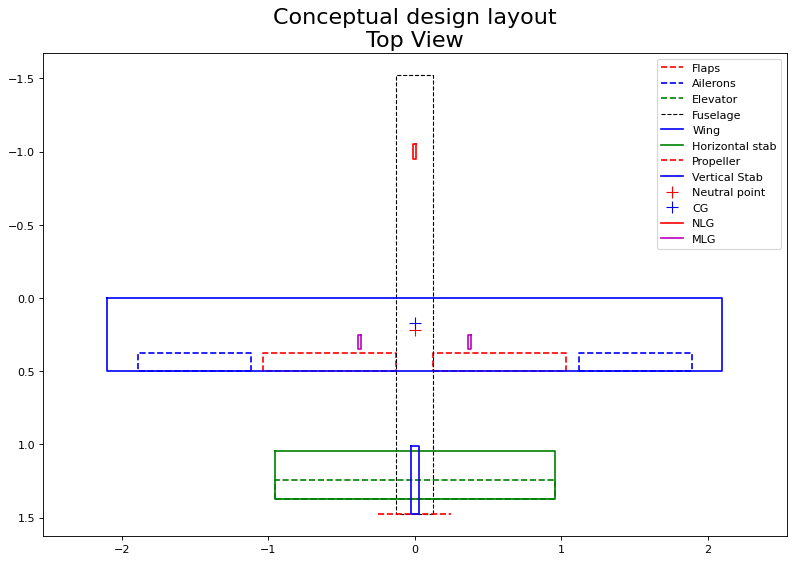

In [53]:
def plot_wing_top()->None:
    x_wing = [-w_span/2, w_span/2, w_span/2, -w_span/2, -w_span/2]
    y_wing = [0, 0, w_chord, w_chord, 0]

    plt.plot(x_wing, y_wing, 'b-', label='Wing')

def plot_flaps_top()->None:
    x_flaps = [fus_width/2, w_span/2*w_flaps_span_stations[1], \
        w_span/2*w_flaps_span_stations[1], fus_width/2, fus_width/2]
    y_flaps = [w_chord, w_chord, (1-w_flaps_chord_ratio)*w_chord, (1-w_flaps_chord_ratio)*w_chord, w_chord]

    plt.plot(x_flaps, y_flaps, 'r--', label='Flaps')
    plt.plot([-x for x in x_flaps], y_flaps, 'r--')

def plot_ht_top()->None:
    x_ht = [-ht_span/2, ht_span/2, ht_span/2, -ht_span/2, -ht_span/2]

    y_LE_ht = 0.25*w_chord + ht_arm - 0.25*ht_chord
    y_ht = [y_LE_ht, y_LE_ht, y_LE_ht+ht_chord, y_LE_ht+ht_chord, y_LE_ht]

    plt.plot(x_ht, y_ht, 'g-', label='Horizontal stab')

def plot_vt_top()->None:
    x_vt = vt_chord*vt_t_c * np.array([-1/2, 1/2, 1/2, -1/2, -1/2])
    y_LE_vt = 0.25*w_chord + vt_arm - 0.25*vt_chord
    y_vt = [y_LE_vt, y_LE_vt, y_LE_vt+vt_chord, y_LE_vt+vt_chord, y_LE_vt]

    plt.plot(x_vt, y_vt, 'b-', label='Vertical Stab')


def plot_np_top(np_x:float)->None:
    plt.plot(0, np_x, 'r+', markersize=10, label='Neutral point')

def plot_cg_top(cg_x: float)->None:
    plt.plot(0, cg_x, 'b+', markersize=10, label='CG')

def plot_fuselage_top()->None:
    x_fus = [fus_width/2, fus_width/2, -fus_width/2, -fus_width/2, fus_width/2]

    y_aft = 0.25*w_chord + max(ht_arm + 0.75*ht_chord, vt_arm + 0.75*vt_chord)
    y_fus = [y_aft, y_aft-fus_length, y_aft-fus_length, y_aft, y_aft]

    plt. plot(x_fus, y_fus, 'k--', linewidth='1', label='Fuselage')

def plot_ailerons_top(y_i, y_o, ail_chord_ratio)->None:
    x_ail = [w_span/2*y for y in [y_i, y_o, y_o, y_i, y_i]]

    y_ail = [0, 0, -ail_chord_ratio*w_chord, -ail_chord_ratio*w_chord, 0]
    # translate to wing trailing edge
    y_ail = [w_chord+x for x in y_ail]

    plt.plot(x_ail, y_ail, 'b--', label='Ailerons')
    plt.plot([-x for x in x_ail], y_ail, 'b--')

def plot_elevator_top()->None:
    x_e = [-ht_span/2, ht_span/2, ht_span/2, -ht_span/2, -ht_span/2]

    y_TE_e = 0.25*w_chord + ht_arm + 0.75*ht_chord
    y_e = [0, 0, -ht_chord*elev_chord_ratio, -ht_chord*elev_chord_ratio, 0]
    # translate to elevator leading edge
    y_e = [y_TE_e+y for y in y_e]

    plt.plot(x_e, y_e, 'g--', label='Elevator')

def plot_landing_gear_top()->None:
    # Nose Landing Gear
    nosewheel_X = [ \
        lg_wheel_thickness/2, lg_wheel_thickness/2, \
        -lg_wheel_thickness/2, -lg_wheel_thickness/2, \
        lg_wheel_thickness/2]
    nosewheel_Y = [ \
        lg_nose_x - lg_wheel_diam/2, lg_nose_x + lg_wheel_diam/2, \
        lg_nose_x + lg_wheel_diam/2, lg_nose_x - lg_wheel_diam/2, \
        lg_nose_x - lg_wheel_diam/2
        ]
    plt.plot(nosewheel_X, nosewheel_Y, 'r-', label='NLG')

    # Main Landing Gear
    mainwheel_X = [ \
    lg_wheel_thickness/2, lg_wheel_thickness/2, \
    -lg_wheel_thickness/2, -lg_wheel_thickness/2, \
    lg_wheel_thickness/2]
    mainwheel_X_right = [x + lg_track/2 for x in mainwheel_X]
    mainwheel_X_left = [x - lg_track/2 for x in mainwheel_X]

    mainwheel_Y = [ \
    lg_main_x - lg_wheel_diam/2, lg_main_x + lg_wheel_diam/2, \
    lg_main_x + lg_wheel_diam/2, lg_main_x - lg_wheel_diam/2, \
    lg_main_x - lg_wheel_diam/2
    ]

    plt.plot(mainwheel_X_right, mainwheel_Y, 'm-')
    plt.plot(mainwheel_X_left, mainwheel_Y, 'm-', label='MLG')

def plot_propeller_top()->None:
    y_prop = 0.25*w_chord + max(ht_arm + 0.75*ht_chord, vt_arm + 0.75*vt_chord)
    x_prop = [-prop_diameter/2, prop_diameter/2]
    plt.plot(x_prop, [y_prop, y_prop], 'r--', label='Propeller')


fig = plt.figure(figsize=(12,8), dpi=80)
fig.gca().set_title('Conceptual design layout\nTop View', fontsize=20)
plot_flaps_top()
plot_ailerons_top(ail_y_i, ail_y_o, ail_chord_ratio)
plot_elevator_top()
plot_fuselage_top()
plot_wing_top()
plot_ht_top()
plot_propeller_top()
plot_vt_top()
plot_np_top(np_x)
plot_cg_top(cg_x)
plot_landing_gear_top()
plt.axis('equal')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

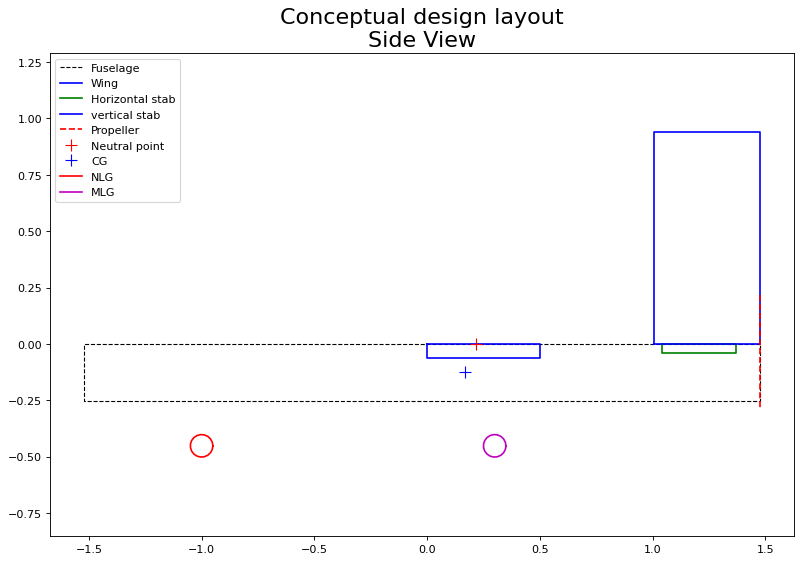

In [50]:
def plot_wing_side()->None:
    x_wing = [0, 0, w_chord, w_chord, 0]
    y_wing = [0, -w_t_c*w_chord, -w_t_c*w_chord, 0, 0]

    plt.plot(x_wing, y_wing, 'b-', label='Wing')

def plot_ht_side()->None:
    y_ht = [0, -ht_t_c*ht_chord, -ht_t_c*ht_chord, 0, 0]

    x_LE_ht = 0.25*w_chord + ht_arm - 0.25*ht_chord
    x_ht = [x_LE_ht, x_LE_ht, x_LE_ht+ht_chord, x_LE_ht+ht_chord, x_LE_ht]

    plt.plot(x_ht, y_ht, 'g-', label='Horizontal stab')

def plot_vt_side()->None:
    y_vt = [0, vt_span, vt_span, 0, 0]

    x_LE_vt = 0.25*w_chord + vt_arm - 0.25*vt_chord
    x_vt = [x_LE_vt, x_LE_vt, x_LE_vt+vt_chord, x_LE_vt+vt_chord, x_LE_vt]

    plt.plot(x_vt, y_vt, 'b-', label='vertical stab')


def plot_np_side(np_x:float)->None:
    plt.plot(np_x, 0, 'r+', markersize=10, label='Neutral point')

def plot_cg_side(cg_x: float)->None:
    plt.plot(cg_x, -fus_height/2, 'b+', markersize=10, label='CG')

def plot_fuselage_side()->None:
    y_fus = [0, 0, -fus_height, -fus_height, 0]

    x_aft = 0.25*w_chord + max(ht_arm + 0.75*ht_chord, vt_arm + 0.75*vt_chord)
    x_fus = [x_aft, x_aft-fus_length, x_aft-fus_length, x_aft, x_aft]

    plt. plot(x_fus, y_fus, 'k--', linewidth='1', label='Fuselage')

def plot_propeller_side()->None:
    x_aft = 0.25*w_chord + max(ht_arm + 0.75*ht_chord, vt_arm + 0.75*vt_chord)
    x_prop = [x_aft, x_aft]
    y_prop = [-0.035 + prop_diameter/2, -0.035 - prop_diameter/2]
    plt.plot(x_prop, y_prop, 'r--', label='Propeller')

def plot_landing_gear_side()->None:
    wheel_X = lg_wheel_diam/2*np.cos(np.linspace(0, 2*np.pi, 20))
    wheel_Y = lg_wheel_diam/2*np.sin(np.linspace(0, 2*np.pi, 20))

    nosewheel_axis = [lg_nose_x, -fus_height-lg_height+lg_wheel_diam/2]
    mainwheel_axis = [lg_main_x, -fus_height-lg_height+lg_wheel_diam/2]

    plt.plot(nosewheel_axis[0]+wheel_X, nosewheel_axis[1]+wheel_Y, 'r-', label='NLG')
    plt.plot(mainwheel_axis[0]+wheel_X, mainwheel_axis[1]+wheel_Y, 'm-', label='MLG')

fig = plt.figure(figsize=(12,8), dpi=80)
fig.gca().set_title('Conceptual design layout\nSide View', fontsize=20)
plot_fuselage_side()
plot_wing_side()
plot_ht_side()
plot_vt_side()
plot_propeller_side()
plot_np_side(np_x)
plot_cg_side(cg_x)
plot_landing_gear_side()
plt.axis('equal')
plt.legend()
plt.show()